In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import torch.nn.functional as F

from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
NUM_EPOCHS = 30
BATCH_SIZE = 128

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

training_data = MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_data = MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

In [5]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [6]:
train_dataloader = DataLoader(training_data, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


In [7]:
# not using dropout https://bleyddyn.github.io/2020-01-14-vae-dropout

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.2),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
        )

        self.mean = nn.Linear(hidden_size, latent_size)
        self.ln_var = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)

        mean = self.mean(x)
        ln_var = self.ln_var(x)

        return mean, ln_var

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.LeakyReLU(0.2),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
        )

        self.output = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        out = self.output(x)
        return out

class VAE(nn.Module):
    
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()

        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(input_size, hidden_size, latent_size)
        self.reparam = lambda mean, std : mean  + torch.randn_like(std) * std

        self.loss = self._loss
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        
    def _loss(self, x_hat):
        reconst_loss = F.binary_cross_entropy(x_hat, self.x, reduction='sum')
        KLD = - 0.5 * torch.sum(1 + self.ln_var - self.mean.pow(2) - self.ln_var.exp())
        return reconst_loss + KLD

    def forward(self, x):
        self.x = x
        self.mean, self.ln_var = self.encoder(self.x)

        std = torch.exp(self.ln_var * 0.5)
        self.z = self.reparam(self.mean, std)

        x_hat = self.decoder(self.z)

        return x_hat

In [8]:
def train(dataloader, model, device):
    size = len(dataloader.dataset)
    for batch, (X, _) in enumerate(dataloader):
        X = X.view(-1, 28*28).to(device)

        x_hat = model(X)
        loss = model.loss(x_hat)

        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item() / BATCH_SIZE, batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
model = VAE(28*28, 100, 400).to(device)

print(model)

for t in range(NUM_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, device)
print("Done!")

VAE(
  (encoder): Encoder(
    (layer1): Sequential(
      (0): Linear(in_features=784, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (mean): Linear(in_features=100, out_features=400, bias=True)
    (ln_var): Linear(in_features=100, out_features=400, bias=True)
  )
  (decoder): Decoder(
    (layer1): Sequential(
      (0): Linear(in_features=400, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (output): Sequential(
      (0): Linear(in_features=100, out_features=784, bias=True)
      (1): Sigmoid()
    )
  )
)
Epoch 1
-------------------------------
loss: 544.881958  [    0/60000]
loss: 207.045563  [12800/60000]
loss: 201.531342  [25600/60000]
loss: 18

In [18]:
def show_image(x, idx):
    x = x.view(BATCH_SIZE, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

In [23]:
with torch.no_grad():
    noise = torch.randn(BATCH_SIZE, 400).to(device)
    generated_images = model.decoder(noise)

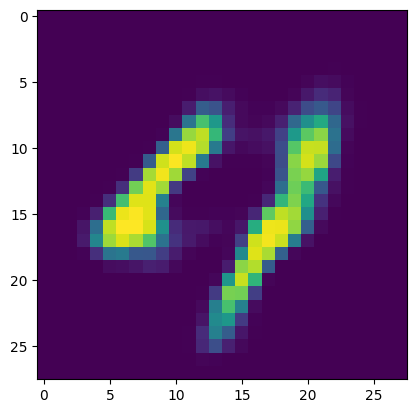

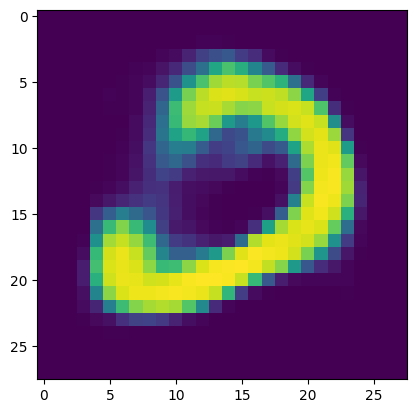

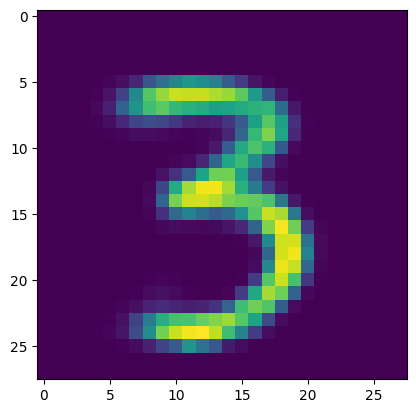

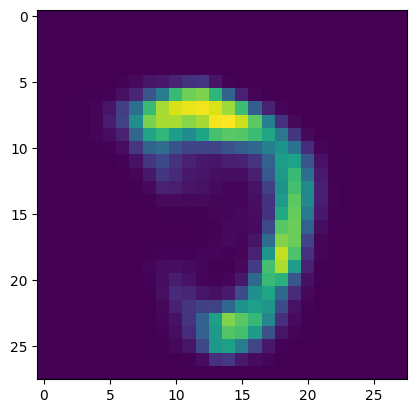

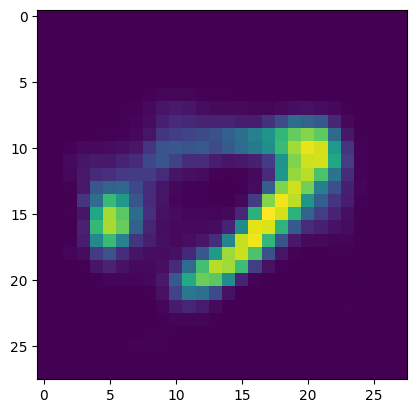

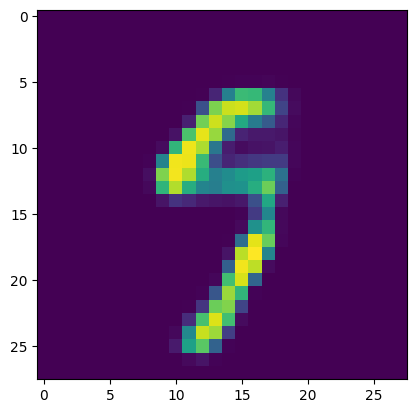

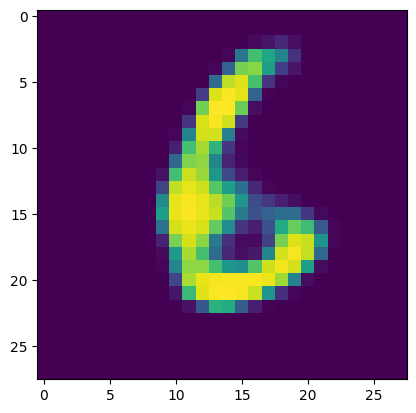

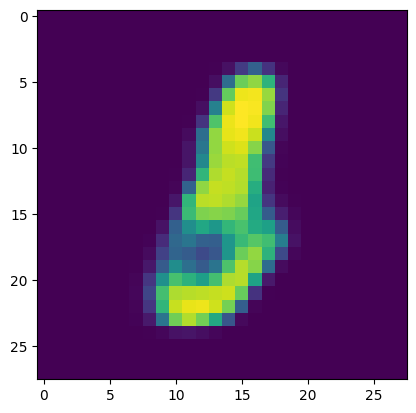

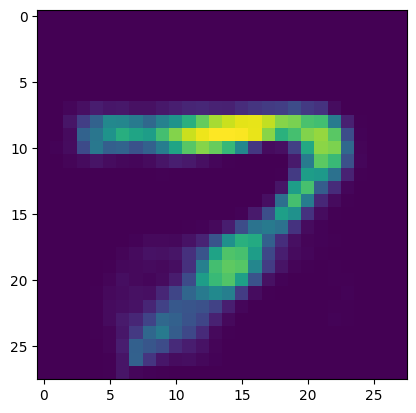

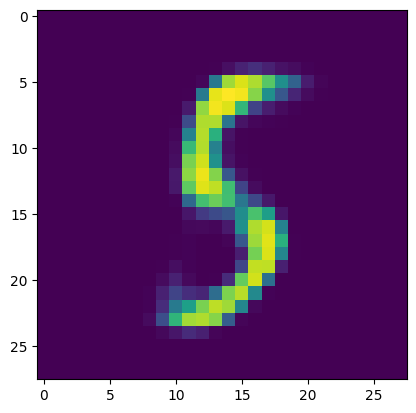

In [24]:
for i in range(10):
    show_image(generated_images, idx=i)